In [122]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

import h5py
from scipy.fft import rfft, rfftfreq

from scipy.signal.windows import hann
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

In [121]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/lorentz_force/analysis_notebook/../analysis_utils.py'>

In [3]:
rho = 2000 # kg/m^3
m = rho * (83e-9)**3 * 4 * np.pi / 3

In [4]:
def get_sz_measured(dt, zz, n_spectrum, n_chunk, c_mv):
    fs = int(np.ceil(1 / dt))

    size_per_chunk = int(zz.size / n_chunk)
    hann_window = hann(size_per_chunk)

    # Correction factor for Hann windowing
    # See https://dsp.stackexchange.com/questions/93512/effects-of-hanning-window-on-power
    hann_psd_scaling = np.sum(hann_window**2)

    ff, s_zzs, s_ffs = None, [], []
    for i in range(n_spectrum):
        zz_calc = zz[i*size_per_chunk : (i+1)*size_per_chunk]
        zz_windowed = hann_window * zz_calc

        s_zz = np.abs(rfft(zz_windowed))**2 / (fs * hann_psd_scaling)
        s_zzs.append(s_zz)

        ff = rfftfreq(size_per_chunk, dt)

    s_zs = 2 * np.array(s_zzs)
    sz_measured = np.mean(s_zs, axis=0) * c_mv**2
    
    return ff, sz_measured

def voigt(xx, A, x0, sigma, gamma):
    return A * voigt_profile(xx-x0, sigma, gamma)

def fit_sigma_voigt(ff, sz, gamma=None):
    fit_idx_voigt = np.logical_and(ff > 47000, ff < 53000)

    popt, pcov = curve_fit(lambda xx, A, f0, sigma, gamma: voigt(xx, A, f0, sigma, gamma), ff[fit_idx_voigt]*2*np.pi, sz[fit_idx_voigt], 
                           p0=[3e-18, 50500*2*np.pi, 50*2*np.pi, 1*2*np.pi], sigma=sz[fit_idx_voigt])
    
    return popt

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_convolved_lineshape(omega, A, omega0, sigma, gamma):
    xx_gauss = np.arange(-400*2*np.pi, 400*2*np.pi, 1)
    gauss_kernel = gauss(xx_gauss, A=1, mu=0, sigma=sigma)
    gauss_kernel /= np.sum(gauss_kernel)

    xx = np.arange(20000*2*np.pi, 120000*2*np.pi, 1)
    actual_lineshape = A / ((xx**2 - omega0**2)**2 + gamma**2 * xx**2)
    
    convolved_lineshape = np.convolve(gauss_kernel, actual_lineshape, 'same')
    return np.interp(omega, xx, convolved_lineshape)

#### Get the calibrated spectrum

In [5]:
_files = [
    r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_0.hdf5',
    r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_1.hdf5',
    r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_2.hdf5',
    r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_3.hdf5',
    r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250731_2e-8mbar_electric_calibration/20250731_11e_2_5vpp_93khz_z_electrode1_4.hdf5',
]

# c_mvs = utils.get_c_mv(_files, [2.5], 93000*2*np.pi, passband=(91700, 94300), charge=11, n_chunk=60, efield=106)
# c_mv  = np.mean(c_mvs)

c_mv = 1.9653656048711584e-07


In [55]:
attrs, tts = utils.get_timestreams(file=_files[0], channels=['d'], attrs=['delta_t'])
dt, zz = attrs[0], tts[0]

# ff, pp = utils.get_psd(dt=dt, zz=dd)
ff, sz_measured = get_sz_measured(dt, zz, n_spectrum=10, n_chunk=400, c_mv=c_mv)

A, omega0, sigma, gamma_voigt = fit_sigma_voigt(ff, sz_measured)

gamma = gamma_voigt * 2
convolved_lineshape = gaussian_convolved_lineshape(ff*2*np.pi, 1, omega0, sigma, gamma)
chi_2_convolved = (1 / (m**2)) * convolved_lineshape

sf_measured_convolved = sz_measured / (chi_2_convolved)


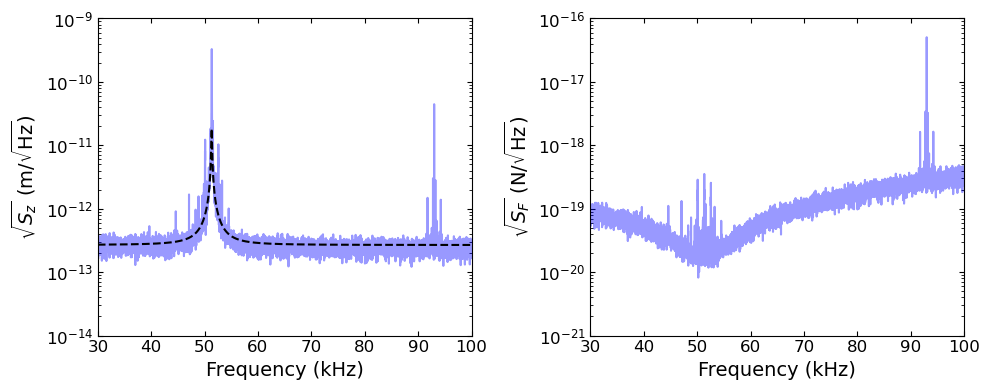

In [9]:
fit_idx = np.logical_and(ff > 200000, ff < 250000)
sz_noisefloor = np.mean(sz_measured[fit_idx])
omega = ff * 2 * np.pi

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(ff/1000, np.sqrt(sz_measured), color='b', alpha=0.4)
axes[0].plot(ff/1000, np.sqrt(voigt(omega, A, omega0, sigma, gamma_voigt) + sz_noisefloor), 'k--', label='Voigt fit')

axes[1].plot(ff/1000, np.sqrt(sf_measured_convolved), color='b', alpha=0.4)

for ax in axes:
    ax.set_xlim(30, 100)
axes[0].set_ylim(1e-14, 1e-9)
axes[1].set_ylim(1e-21, 1e-16)

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('Frequency (kHz)')

axes[0].set_ylabel(r'$\sqrt{S_z}$ (m/$\sqrt{\mathrm{Hz}}$)')
axes[1].set_ylabel(r'$\sqrt{S_F}$ (N/$\sqrt{\mathrm{Hz}}$)')

fig.tight_layout()

We will use this calibration signal as a reference to calibrate the actual measurement into physical force units.

In [83]:
_file = r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250807_2e-8mbar_highfreq/20250807_m350e_369khz_300vpp_withb_0.hdf5'
attrs, tts = utils.get_timestreams(_file, channels=['d', 'g'], attrs=['delta_t'])

dt = attrs[0]
dd, gg = tts[0], tts[1]

zz = dd * c_mv

In [125]:
# Fourier transform the drive and position timestreams
ggf = rfft(gg)
zzf = rfft(zz)
ff = rfftfreq(n=zz.size, d=dt)

In [ ]:
f_drive = ff[np.argmax(ggf)]  # drive frequency (Hz)

half_bandwidth = 250
idx_signal = np.logical_and(ff > f_drive-half_bandwidth, ff < f_drive+half_bandwidth)

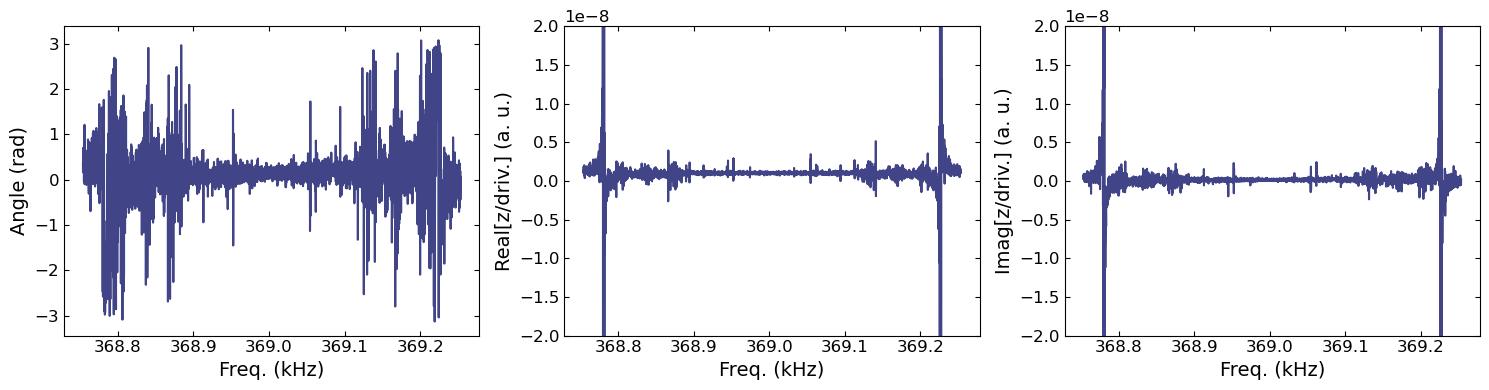

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ff[idx_signal]/1000, np.angle(zzf[idx_signal] / ggf[idx_signal]))
axes[1].plot(ff[idx_signal]/1000, np.real(zzf[idx_signal] / ggf[idx_signal]))
axes[2].plot(ff[idx_signal]/1000, np.imag(zzf[idx_signal] / ggf[idx_signal]))

axes[1].set_ylim(-2e-8, 2e-8)
axes[2].set_ylim(-2e-8, 2e-8)

for ax in axes:
    ax.set_xlabel('Freq. (kHz)')
axes[0].set_ylabel('Angle (rad)')
axes[1].set_ylabel('Real[z/driv.] (a. u.)')
axes[2].set_ylabel('Imag[z/driv.] (a. u.)')

fig.tight_layout()

In [137]:
from scipy.signal import butter, sosfilt

def demodulate(_sig, _lo, f_samp, f_lp):
    mixed_sig = _sig * _lo

    sos = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=f_samp)
    filtered = sosfilt(sos, mixed_sig)
    
    return filtered

def get_eb_comp(dt, zz, gg):
    fs = int(1 / dt)  # Sample frequency

    ee = demodulate(zz, gg, fs, 10)
    bb = demodulate(zz, np.gradient(gg), fs, 10)

    return ee, bb

In [150]:
nfiles = 20

ees_b, ees_b_inv = [], []
bbs_b, bbs_b_inv = [], []
for i in range(nfiles):
    if (i % 5 == 0):   print(i)

    _file_b = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250807_2e-8mbar_highfreq/20250807_m350e_369khz_300vpp_withb_{i}.hdf5'
    attrs, tts = utils.get_timestreams(_file_b, channels=['d', 'g'], attrs=['delta_t'])
    dt = attrs[0]
    dd, gg = tts[0], tts[1]

    ee_b, bb_b = get_eb_comp(dt, dd, gg)
    ees_b.append(ee_b)
    bbs_b.append(bb_b)

    _file_b_inv = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250807_2e-8mbar_highfreq/20250807_m350e_369khz_300vpp_withb_flipped_{i}.hdf5'
    attrs, tts = utils.get_timestreams(_file_b_inv, channels=['d', 'g'], attrs=['delta_t'])
    dt = attrs[0]
    dd, gg = tts[0], tts[1]

    ee_b_inv, bb_b_inv = get_eb_comp(dt, dd, gg)
    ees_b_inv.append(ee_b_inv)
    bbs_b_inv.append(bb_b_inv)

0
5
10
15


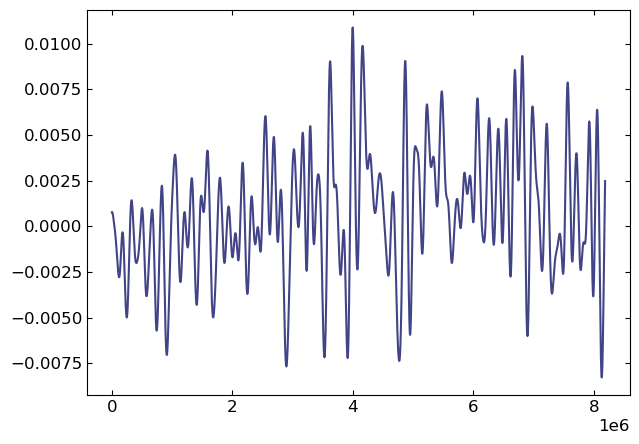

In [171]:
i = 0
idx_start = 200000

plt.plot(bbs_b[i][idx_start:]/ees_b[i][idx_start:] - bbs_b_inv[i][idx_start:]/ees_b_inv[i][idx_start:])


In [176]:
be = np.linspace(-0.005, 0.005, 200)
bc = 0.5 * (be[1:] + be[:-1])

hh_all = np.zeros_like(bc)
for i in range(len(bbs_b)):
    # plt.plot(bbs_b[i] - bbs_b_inv[i])
    idx_start = 200000
    hh, _ = np.histogram(bbs_b[i][idx_start:]/ees_b[i][idx_start:] - bbs_b_inv[i][idx_start:]/ees_b_inv[i][idx_start:], bins=be)
    hh_all += hh

Text(0, 0.5, 'Counts')

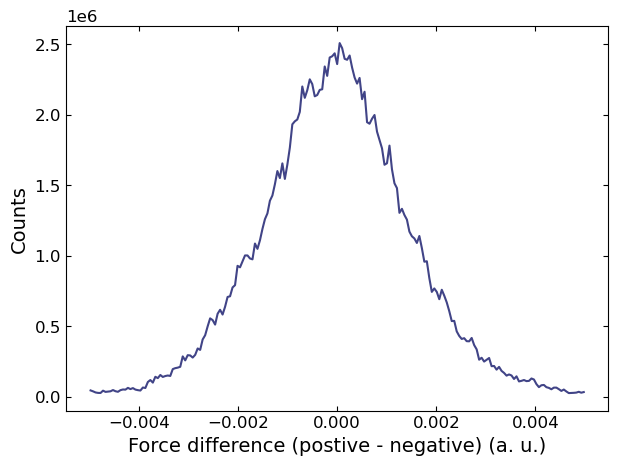

In [181]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(bc, hh_all)
# ax.set_yscale('log')

ax.set_xlabel('Force difference (postive - negative) (a. u.)')
ax.set_ylabel('Counts')

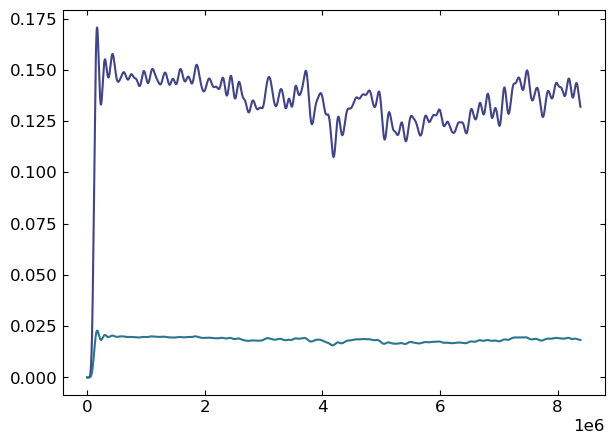

In [ ]:
plt.plot(ee)
plt.plot(bb)

# plt.xlim(1e6, 8e6)
# plt.ylim(0, 0.2)

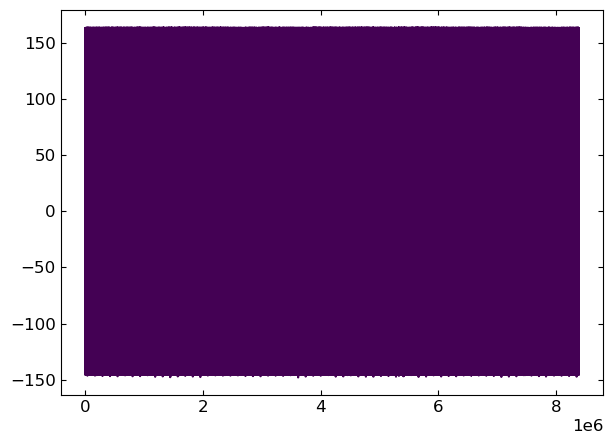

In [75]:
plt.plot(gg * -20)

(269.0, 469.0)

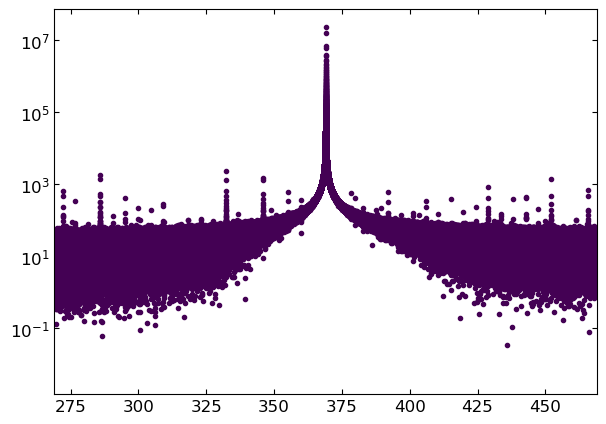

In [82]:
plt.plot(ff/1000, np.abs(ggf), '.')
plt.yscale('log')

plt.xlim(369-100, 369+100)

(0.0, 100.0)

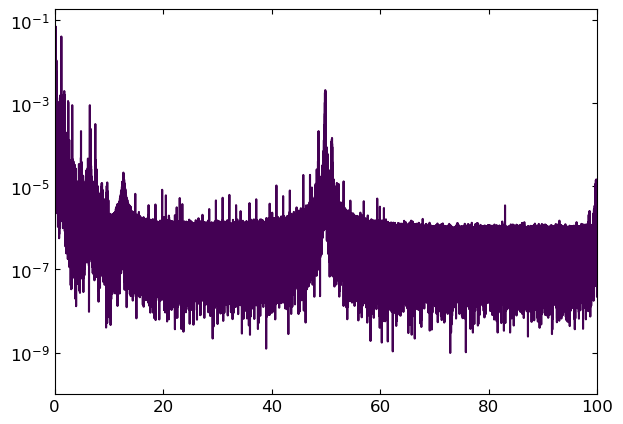

In [60]:
plt.plot(ff/1000, np.abs(zzf))
plt.yscale('log')

# plt.ylim(-1e-7, 1e-7)
plt.xlim(0, 100)

In [ ]:
freq = rfftfreq(n=dd.size, d=2e-6)

In [ ]:
# nfile = 1500
# amps_wb, amps_fb, amps_nob = np.empty(nfile), np.empty(nfile), np.empty(nfile)
# # maxd_wb, maxd_nob = np.empty(nfile), np.empty(nfile)

# for i in range(nfile):
#     if i % 100 == 0:
#         print(i)
#     _file_name = rf"/Volumes/LaCie/lorentz_force/sphere_20250708/20250804_2e-8mbar_newsamp/20250804_m350e_79khz_100vpp_withb_{i}.hdf5"
#     f = h5py.File(_file_name, 'r')
#     dd = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv']/1000
#     gg = f['data']['channel_g'][:] * f['data']['channel_g'].attrs['adc2mv']/1000
#     f.close()

#     _file_name = rf"/Volumes/LaCie/lorentz_force/sphere_20250708/20250804_2e-8mbar_newsamp/20250804_m350e_79khz_100vpp_withb_flipped_{i}.hdf5"
#     f = h5py.File(_file_name, 'r')
#     dd_fb = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv']/1000
#     gg_fb = f['data']['channel_g'][:] * f['data']['channel_g'].attrs['adc2mv']/1000
#     f.close()

#     _file_name_nob = rf"/Volumes/LaCie/lorentz_force/sphere_20250708/20250804_2e-8mbar_newsamp/20250804_m350e_79khz_100vpp_nob_0.hdf5"
#     f = h5py.File(_file_name_nob, 'r')
#     dd_nob = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv']/1000
#     gg_nob = f['data']['channel_g'][:] * f['data']['channel_g'].attrs['adc2mv']/1000
#     f.close()

#     idx_freq = np.argmax(rfft(gg))

#     amps_wb[i] = np.imag(rfft(dd) / rfft(gg))[idx_freq]
#     amps_fb[i] = np.imag(rfft(dd_fb) / rfft(gg_fb))[idx_freq]
#     amps_nob[i] = np.imag(rfft(dd_nob) / rfft(gg_nob))[idx_freq]

# np.savez('amps_20250804_2e-8mbar_newsamp_0_1499.npz', amps_wb=amps_wb, amps_fb=amps_fb, amps_nob=amps_nob)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [178]:
_file_name = rf"/Volumes/LaCie/lorentz_force/sphere_20250708/20250804_2e-8mbar_newsamp/20250804_m350e_79khz_100vpp_withb_{i}.hdf5"
f = h5py.File(_file_name, 'r')
dd = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv']/1000
gg = f['data']['channel_g'][:] * f['data']['channel_g'].attrs['adc2mv']/1000
f.close()

freq = rfftfreq(n=dd.size, d=2e-6)

In [180]:
np.abs(np.max(rfft(gg)))

2756824.3862511697

In [164]:
get_approx_force(amps_wb, bin_size=2*np.pi*(freq[1]-freq[0]), c_mv=c_mv, omega_drive=79000*2*np.pi)

array([5.98909651e-05, 9.50464765e-05, 5.31360122e-05, ...,
       5.66182299e-05, 5.92602317e-05, 5.81748123e-05])

Text(0, 0.5, 'Ampltiude (N)')

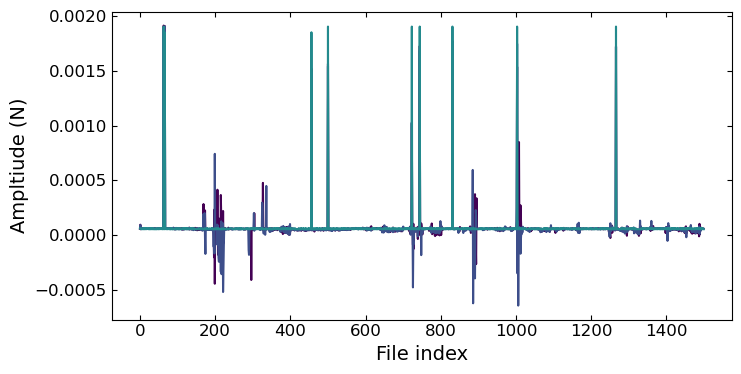

In [167]:
plt.subplots(figsize=(8, 4))

plt.plot(get_approx_force(amps_wb, bin_size=2*np.pi*(freq[1]-freq[0]), c_mv=c_mv, omega_drive=79000*2*np.pi))
plt.plot(get_approx_force(amps_fb, bin_size=2*np.pi*(freq[1]-freq[0]), c_mv=c_mv, omega_drive=79000*2*np.pi))
plt.plot(get_approx_force(amps_nob, bin_size=2*np.pi*(freq[1]-freq[0]), c_mv=c_mv, omega_drive=79000*2*np.pi))

# plt.ylim(-0.02, 0.05)
# plt.xlim(0, 1500)

plt.xlabel('File index')
plt.ylabel('Ampltiude (N)')

In [168]:
def fit_amps_gaus(normalized_amps, bins=None, return_bins=False):
    hhs, bcs, gps = [], [], []
    bins_ret = []
    for amp in normalized_amps:
        if bins is None:
            bin = np.linspace(0, np.max(amp)*1.5, 50)
        else:
            bin = bins
        hh, be = np.histogram(amp, bins=bin)
        bc = 0.5 * (be[1:] + be[:-1])
        
        gp, gcov = curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(amp)), np.std(np.abs(amp))], maxfev=50000)

        hhs.append(hh)
        bcs.append(bc)
        gps.append(gp)
        bins_ret.append(bin)
    
    if return_bins:
        return hhs, bcs, gps, bins_ret
    else:
        return hhs, bcs, gps

In [181]:
bins = np.linspace(-0.05, 0.05, 200)
bc = 0.5 * (bins[1:] + bins[:-1])

hhs, bcs, gps = fit_amps_gaus([amps_wb-amps_nob, 
                               amps_fb-amps_nob,
                               amps_wb-amps_fb,], bins=bins)
# hh_wb_sub, _ = np.histogram(amps_wb - amps_nob, bins=bins)
# hh_fb_sub, _ = np.histogram(amps_fb - amps_nob, bins=bins)
# hh_diff,   _ = np.histogram(amps_wb - amps_fb, bins=bins)

Text(0.5, 0, 'Force difference (a. u.)')

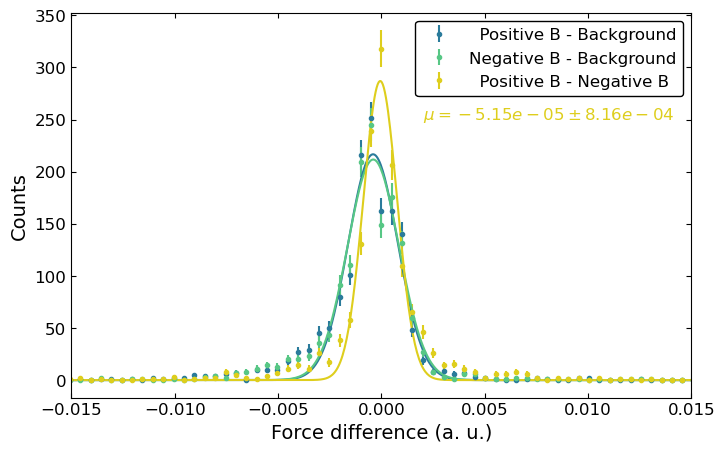

In [195]:
colors = ['#2A7B9B', '#57C785', '#DECE1D']

xx = np.linspace(bins[0], bins[-1], 2000)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.errorbar(bc, hhs[0], yerr=np.sqrt(hhs[0]), fmt='.', color=colors[0], label='  Positive B - Background')
ax.errorbar(bc, hhs[1], yerr=np.sqrt(hhs[1]), fmt='.', color=colors[1] ,label='Negative B - Background')
ax.errorbar(bc, hhs[2], yerr=np.sqrt(hhs[2]), fmt='.', color=colors[2], label='  Positive B - Negative B')

ax.plot(xx, gauss(xx, *gps[0]), color=colors[0])
ax.plot(xx, gauss(xx, *gps[1]), color=colors[1])
ax.plot(xx, gauss(xx, *gps[2]), color=colors[2])

ax.legend(framealpha=1, edgecolor='k')
ax.text(0.002, 250, rf'$\mu = {gps[2][1]:.2e} \pm {gps[2][2]:.2e}$', color=colors[2], fontsize=12)

ax.set_xlim(-0.015, 0.015)

ax.set_ylabel('Counts')
ax.set_xlabel('Force difference (a. u.)')